# T-AMSOS : Simulation Analysis

In [29]:
import os, math, random, shutil, yaml, glob, copy, random, sys,time
import numpy as np
import seaborn as sns
from pytransform3d import rotations as pyro
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit
%matplotlib notebook

In [66]:
# tactoid sim path
tpath = "/Users/saadjansari/Documents/Projects/AMSOS/resultsSummit/Tactoids/scan_f_n400/k_fast/poly/f16"

# Create plots directory
rpath = os.path.join(tpath, 'plots')
if os.path.exists(rpath):
    shutil.rmtree( rpath)
os.mkdir( rpath)

# Specify parameters
analyze_bulk = False
run_visualization = True
run_tests = False

# Load parameters from RunConfig.yaml and ProteinConfig.yaml files
with open( os.path.join(tpath,'RunConfig.yaml')) as f:
    pars1 = yaml.load( f, Loader=yaml.FullLoader)
with open( os.path.join(tpath,'ProteinConfig.yaml')) as f:
    pars2 = yaml.load( f, Loader=yaml.FullLoader)
    
dt = pars1['timeSnap'] # Specify frame step of simulation
boxsize = np.array( pars1['initBoxHigh']) # Specify frame step of simulation

# get filament and protein number
if os.path.exists( os.path.join(tpath, 'TubuleInitial.dat')):
    with open(os.path.join(tpath, 'TubuleInitial.dat'), 'r') as file1:
        nfil = len( file1.readlines() )-2
else:
    nfil = pars1['sylinderNumber']
if os.path.exists( os.path.join(tpath, 'ProteinInitial.dat')):
    with open(os.path.join(tpath, 'ProteinInitial.dat'), 'r') as file1:
        nprot = len( file1.readlines() )-2
else:
    nprot = pars2['freeNumber']

FAratio = np.around( nprot/nfil,1) # filamin to actin ratio

# Determine if filaments are polydisperse or monodisperse
with open( os.path.join(tpath, 'result/result0-399/SylinderAscii_0.dat'), 'r') as file1:
    lens = []
    for line in file1:
        if line.startswith('C'):
            data = line.split()
            pos0 = np.array([float(data[3]), float(data[4]), float(data[5])])
            pos1 = np.array([float(data[6]), float(data[7]), float(data[8])])
            lens.append( np.linalg.norm(pos1-pos0))
if max(lens) - min(lens) < 0.001:
    dispersity = 'Mono'
else:
    dispersity = 'Poly'
    
# title of plots
ftitle='Filamin-Actin ratio = {0}, {1}disperse'.format(FAratio,dispersity)
print(ftitle)

# Display
cols = {
    'cluster': "limegreen",
    'bulk': "mediumvioletred",
    'env': "dodgerblue"
}
lw = 2 # linewidth

plt.close('all')

Filamin-Actin ratio = 6.0, Polydisperse


### Description

This script performs structural and dynamics analysis for a single tactoid simulation. It does so in the following way:

1. Initialization:
    * Create filament and protein objects by extracting data from SylinderAscii_X.dat and ProteinAscii_X.dat files. 
    * Filaments are stored in `ftlist[nFrame][nFilament]`
    * Proteins are stored in `ptlist[nFrame][nFilament]`
    

2. Pre-processing:
    * Find the biggest cluster of filaments (this is our potential tactoid). We do this by running a connected component analysis on a graph with filaments representing nodes and proteins representing edges. This information is stored in `ect[nFrame]`
    * Transform all filaments to the cluster center of mass frame. The cluster has an origin at some $[x_{cm},y_{cm},z_{cm}]$ and a Z-axis that points in the direction of the nematic director (the eigenvector of the nematic tensor $Q$ with the biggest eigenvalue. The transformed filaments are stored in `ftlist2[nFrame][nFilament]`
   
   
3. Analysis:
    * Pair-pair separation: mean separation between filaments as a function of time. This is a measure of density.
    * Pair-pair MSD: mean square displacement of pairs.
    * MSD in z: mean square displacement in Z. Given that the only axis of symmetry is in the Z-direction, looking at MSD_z makes sense.
    * Nematic order: the nematic order (orientation correlation)
    * Xlink energy: mean energy of xlinks as a function of time. 
    * Xlink distance: distance of xlinks from the center of the cluster.
    

We start by defining some utility classes and functions:
* **Filament class / Protein class**: this will store the coordinate information about filaments and proteins.
* **Nearest image convention**: these functions allow one to calculate the distance between points and the mean of points given the box-size for a perdiodic boundary condition.
* **Connected components**: enables finding filament clusters that are connected together by proteins.
* **Confidence interval**: find confidence interval for non-normal distribution using the non-parametrized bootstrap method.
* **AnalysisBook class**: Container for functions that do analysis on filament lists.


#### Notes:
    * The tactoid/bundle is characterized by a single rotation axis of symmetry along the nematic director. 
      There is no axis of symmetry in the XY-plane.
    * We can transform the tactoid so that the nematic director points in the +Z direction.
    * We cannot transform to the complete tactoid reference frame because of the ambiguity of 
      definition of the X and Y axes. 
    * Since we use periodic boundary conditions, we should account for this during analysis.

### Utility Functions:
#### Filament and Protein class:

In [67]:
# Filament class
class Filament():
    def __init__(self, pos0, pos1, radius,gid):
        self.radius = radius
        self.pos0 = pos0
        self.pos1 = pos1
        self.gid = gid
    def GetCenter(self,boxsize):
        return getMean(self.pos0, self.pos1,boxsize)
    def GetLength(self,boxsize):
        xi = getDistance(self.pos1,self.pos0,boxsize)
        return np.linalg.norm( xi)
    def GetOrientation(self,boxsize):
        xi = self.pos1 - self.pos0
        return xi/np.sqrt(xi.dot(xi))

    def Plot3(self,ax, col="red"):
        ax.plot3D( [self.pos0[0], self.pos1[0]], [self.pos0[1], self.pos1[1]], [self.pos0[2], self.pos1[2]], col)
    def GetStringtoWrite(self):
        return 'C {0} {1} {2:0.6f} {3:0.6f} {4:0.6f} {5:0.6f} {6:0.6f} {7:0.6f}\n'.format(
        self.gid, self.radius,
        self.pos0[0], self.pos0[1], self.pos0[2],
        self.pos1[0], self.pos1[1], self.pos1[2])
    def __repr__(self):
        return "Filament()"
    def __str__(self):
        return 'Filament {0}:\n  pos0: {1}\n  pos1: {2}\n  radius: {3}'.format(self.gid, self.pos0, self.pos1,self.radius)
    
# Protein class
class Protein():
    def __init__(self, pos0, pos1, link0, link1, gid):
        self.pos0 = pos0
        self.pos1 = pos1
        self.link0 = link0
        self.link1 = link1
        self.gid = gid
    def GetCenter(self,boxsize):
        return getMean(self.pos0, self.pos1,boxsize)
    def GetLength(self,boxsize):
        xi = getDistance(self.pos1,self.pos0,boxsize)
        return np.linalg.norm( xi)
    def GetOrientation(self,boxsize):
        if link0 is not -1 and link1 is not -1:
            xi = self.pos1 - self.pos0
            return xi/np.sqrt( xi.dot(xi))
        else:
            return None
        
    def Plot3(self,ax,col="blue"):
        ax.plot3D( [self.pos0[0], self.pos1[0]], [self.pos0[1], self.pos1[1]], [self.pos0[2], self.pos1[2]], col)
    def GetStringtoWrite(self):
        return 'P {0} 0 {2:0.6f} {3:0.6f} {4:0.6f} {5:0.6f} {6:0.6f} {7:0.6f} {8} {9} \n'.format(
        self.gid, self.radius,
        self.pos0[0], self.pos0[1], self.pos0[2],
        self.pos1[0], self.pos1[1], self.pos1[2],
        self.link0, self.link1)
    def __repr__(self):
        return "Protein()"
    def __str__(self):
        return 'Protein {0}:\n  pos0: {1}\n  pos1: {2}\n  Links: {3}--{4}'.format(self.gid, self.pos0, self.pos1, self.link0, self.link1)


#### Nearest image convention:
Distance and Mean calculation functions that use the nearest image convention.

In [68]:
def getDistance(p0,p1,boxsize):
    # distance between two points in the nearest image convention
    # can use multidimensional arrays for distances between multiple points
    dist = np.absolute( p1-p0)
    for idx in range(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            dist[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            dist[:,idx] -= k*boxsize[idx]
        elif len(dist.shape) == 3:
            k = np.floor( dist[:,:,idx]/(0.5*boxsize[idx]))
            dist[:,:,idx] -= k*boxsize[idx]
    return np.absolute(dist)
def getMean(p0,p1,boxsize):
    # mean of the two points in the nearest image
    dist = np.absolute(p1-p0)
    for idx in range(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            p1[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            p1[:,idx] -= k*boxsize[idx]
        elif len(dist.shape) == 3:
            k = np.floor( dist[:,:,idx]/(0.5*boxsize[idx]))
            p1[:,:,idx] -= k*boxsize[idx]
    return (p0 + p1)/2

#### Connected Components:
We use Depth-First-Search (DFS) to find connected components in an undirected graph. This algorithm can be found <a href="https://www.geeksforgeeks.org/connected-components-in-an-undirected-graph/" target="_blank">here</a>.
1) The vertices represent filaments, and the edges represent proteins (links).

2) We add to our graph, edges corresponding to proteins.

3) We employ DFS:

    i) Initialize all vertices as not visited.
    ii) Do following for every vertex 'v'.
       (a) If 'v' is not visited before, call DFSUtil(v)
       (b) Print new line character

    DFSUtil(v)
       (a) Mark 'v' as visited.
       (b) Print 'v'
       (c) Do following for every adjacent 'u' of 'v'.
             If 'u' is not visited, then recursively call DFSUtil(u)

In [69]:
# Python code to get connected components in an undirected graph 
# This code is contributed by Abhishek Valsan
class Graph: 
      
    # init function to declare class variables 
    def __init__(self,V): 
        self.V = V 
        self.adj = [[] for i in range(V)] 
  
    def DFSUtil(self, temp, v, visited): 
  
        # Mark the current vertex as visited 
        visited[v] = True
  
        # Store the vertex to list 
        temp.append(v) 
  
        # Repeat for all vertices adjacent 
        # to this vertex v 
        for i in self.adj[v]: 
            if visited[i] == False: 
                  
                # Update the list 
                temp = self.DFSUtil(temp, i, visited) 
        return temp
  
    # method to add an undirected edge 
    def addEdge(self, v, w): 
        self.adj[v].append(w) 
        self.adj[w].append(v) 
  
    # Method to retrieve connected components 
    # in an undirected graph 
    def connectedComponents(self): 
        visited = [] 
        cc = [] 
        for i in range(self.V): 
            visited.append(False) 
        for v in range(self.V): 
            if visited[v] == False: 
                temp = [] 
                cc.append(self.DFSUtil(temp, v, visited)) 
        cc = [sorted(ec) for ec in cc]
        cc = sorted(cc, key=len, reverse=True)
        return cc

#### Confidence interval (non-normal distribution)
We do this via the bootstraping non-parametrized method

In [70]:
def getCIBootstrap(data,alpha,n_iter=10000):
    boot_mu = [np.mean(np.random.choice(x, len(x))) for _ in range(iteration)]
    beta = (1-alpha)/2
    lo_x_boot = np.percentile(boot_mu, 100*beta)
    hi_x_boot = np.percentile(boot_mu, 100*(1-beta))
    return (lo_x_boot, hi_x_boot)

#### Analysis Book:

In [71]:
class AnalysisBook():
    def __init__(self,boxsize):
        self.boxsize = boxsize
    # refpair to all other filament distances
    def R2Adistance(self, rfil, fils):
        dist = np.zeros(( len(fils)-1,3))
        cnt=0
        for cnt,f1 in enumerate(fils):
            if f1.gid is not rfil.gid:
                dist[cnt,:] = getDistance( rfil.GetCenter(self.boxsize), f1.GetCenter(self.boxsize),self.boxsize)
                cnt+=1
        return dist
    # pair to pair distances
    def P2Pdistance(self, fils):
        # only computer for upper triangle. Then add the transpose to get bottom triangle
        p00 = np.zeros(( len(fils), len(fils),3))
        p01 = np.zeros(( len(fils), len(fils),3))
        p10 = np.zeros(( len(fils), len(fils),3))
        p11 = np.zeros(( len(fils), len(fils),3))
        for i1,f1 in enumerate(fils):
            for i2,f2 in enumerate(fils):
                if i1 > i2:
                    p00[i1,i2,:] = f1.pos0
                    p01[i1,i2,:] = f1.pos1
                    p10[i1,i2,:] = f2.pos0
                    p11[i1,i2,:] = f2.pos0
        c0 = getMean( p00,p01, self.boxsize)
        c1 = getMean( p10,p11, self.boxsize)
        dist = getDistance(c0,c1,self.boxsize)
        dist = dist + np.transpose(dist, (1,0,2) )
        return dist
    # get center of mass
    def COM(self, fils):
        sumList = np.zeros((1,3))
        for fil in fils:
            sumList += fil.GetLength(self.boxsize)*getDistance(np.array([0,0,0]), fil.GetCenter(self.boxsize), self.boxsize )
        COM = sumList / np.sum( [f.GetLength(self.boxsize) for f in fils])
        return COM[0]
    # Get nematic tensor
    def NematicTensor( self,fils):
        orientList = []
        for fil in fils:
            orientList.append(fil.GetOrientation( self.boxsize) )
        PList = np.array(orientList)
        QList = np.array([np.outer(p, p) for p in PList])
        polarOrder = np.mean(PList, axis=0)
        nematicOrder = np.mean(QList, axis=0) - np.identity(3)/3
        return nematicOrder, polarOrder
    def NematicOrder( self,fils):
        Q,_ = self.NematicTensor(fils)
        return np.sqrt(np.tensordot(Q, Q)*1.5)
    # Get reference frame nematic basis vectors
    def GetBasisVectors( self,fils):
        # basis vectors are the eigenvectors of the nematic tensor Q in order of magnitude of their eigenvalues
        Q,_ = self.NematicTensor(fils)
        w,v = np.linalg.eig( Q)
        idx = np.argsort(np.sqrt(w*w))
        v = v[:,idx]
        w = w[idx]
        idx = [0,1,2]
        if np.any( np.around( np.cross( v[:,0], v[:,1]),2) != np.around( v[:,2],2) ):
            idx1 = idx[0]
            idx2 = idx[1]
            idx = [idx2, idx1, idx[2]]
        w = w[idx]
        v = v[:,idx]  
        return w,v
    def FilsIdxInsideTac_T1_T2( self, tilist,t1,t2):
    # find the filaments that are remain inside a tactoid between times t1 and t2
    # the ids of filaments inside tac are stored in tilist
        cc = tilist[t1]
        for tt in range(t1, t2+1):
            cc = list( set.intersection(set(cc), set(tilist[tt])))
            #cc = [val for val in tilist[tt] if val in cc] 
        return cc
    def FilsIdxOutsideTac_T1_T2( self, tilist,t1,t2, nF):
    # find the filaments that remain outside a tactoid between times t1 and t2
    # the ids of filaments inside tac are stored in tilist
        cc = list(range(0,nF))
        for tt in range(t1, t2+1):
            for xx in tilist[tt]:
                if xx in cc:
                    cc.remove(xx)
        return cc
    def FilsInsideTac( self, flist, idx):
    # find the filaments that are remain inside a tactoid between times t1 and t2
    # the ids of filaments inside tac are stored in tilist
        ff = []
        for ec in idx:
            ff.append( flist[ec])
        return ff
    def P2PInsideTac( self, p2p, idx):
        # returns a mini matrix corresponding to the pairs inside tac. Needs the full p2p matrix.
        
        # delete rows and column not corresponding to those in idx
        rm = list( set.difference(set( range( p2p.shape[0]) ), set( idx )))
        #rm = [xx for xx in range( p2p.shape[0]) if xx not in idx]
        p2pdel = np.delete( p2p, rm, axis=0)
        p2pdel = np.delete( p2pdel, rm, axis=1)
        return p2pdel

### SCRIPT:
#### Initialization
We begin by loading the filament and protein data from files and storing them as objects.

In [72]:
# Get key to sort through file indices
def fileKey(f):
    k = int(f[f.rfind("_")+1:f.rfind(".")])
    return k

# find filament files
files = glob.glob( os.path.join(tpath, 'result/result*/SylinderAscii_*.dat'))
files = sorted(files, key=fileKey)
ftlist = []
for fil in files:
    flist = []
    with open(fil, 'r') as file1:
        for line in file1:
            if line.startswith('C'):
                data = line.split()
                gid = int(data[1])
                radius = float(data[2])
                pos0 = np.array([float(data[3]), float(data[4]), float(data[5])])
                pos1 = np.array([float(data[6]), float(data[7]), float(data[8])])
                flist.append( Filament(pos0, pos1, radius,gid))
    ftlist.append(flist)
                         
# Read protein file
files = glob.glob( os.path.join(tpath, 'result/result*/ProteinAscii_*.dat'))
files = sorted(files, key=fileKey)
ptlist = []
for fil in files:
    plist = []
    with open(fil, 'r') as file2:
        for line in file2:
            if line.startswith('P'):
                data = line.split()
                gid = int(data[1])
                pos0 = np.array([float(data[3]), float(data[4]), float(data[5])])
                pos1 = np.array([float(data[6]), float(data[7]), float(data[8])])
                link0 = int(data[9])
                link1 = int(data[10])
                plist.append( Protein(pos0, pos1, link0, link1, gid))
    ptlist.append(plist)
    
# Toss out zeroth timestep
ftlist.pop(0)
ptlist.pop(0)

AC = AnalysisBook(boxsize)
nT = len(ftlist)
nF = len(ftlist[0])
nP = len(ptlist[0])
print('Simulation details:\n  Filaments: {0}\n  Xlinks: {1}\n  Frames: {2}'.format(nF,nP,nT))

Simulation details:
  Filaments: 400
  Xlinks: 2400
  Frames: 150


#### Filaments inside biggest cluster

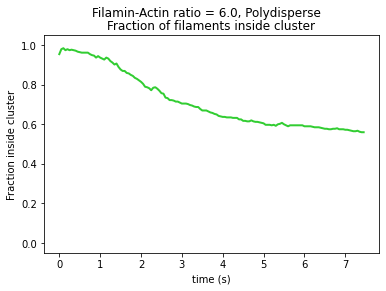

In [73]:
if not analyze_bulk:
    cct = []
    cct2 = np.zeros( (nT,nF),dtype=bool)
    for it in range(nT):

        # Create a graph for filaments
        g = Graph( len(ftlist[it]) ); 

        # add edges to the graph (each edge represents a binding xlink)
        for p in ptlist[it]:
            if p.link0 is not -1 and p.link1 is not -1:
                g.addEdge(p.link0, p.link1) 

        # find connected components
        cc = g.connectedComponents()
        cct2[[it for i in range(len(cc[0]))], cc[0]] = True
        cct.append( cc[0])
else:
    cct = [range(nF) for ii in range(nT)]

    
ftlist_trimmed = []
for row in cct2:
    fff = []
    idx = np.where(row)[0].tolist()
    for el in idx:
        fff.append( ftlist[it][el])
    ftlist_trimmed.append( fff)
    
if run_visualization:
    %matplotlib inline
    fig,ax = plt.subplots()
    nft = [len(ii)/nF for ii in cct]
    ax.plot( dt*np.arange(nT) , nft, color=cols['cluster'], linewidth=lw)
    ax.set(xlabel='time (s)', ylabel='Fraction inside cluster', title='Fraction of filaments inside cluster', ylim=[-0.05,1.05])
    fig.suptitle(ftitle)
    fig.savefig( os.path.join(rpath,'fractionInCluster.pdf') , bbox_inches='tight', dpi=600)

#### Coordinate transformation:

In [18]:
t0 = time.time()
ftlist2 = copy.deepcopy( ftlist)
# ptlist2 = copy.deepcopy( ptlist)
world_origin = np.array([0,0,0])
world_vec = np.identity(3)
    
for it in range(nT):

    obj_origin = AC.COM( ftlist_trimmed[it]).transpose()
    w,obj_vec = AC.GetBasisVectors( ftlist_trimmed[it])
    T = (world_origin - obj_origin)
    
    # Get vector perp to z-axis and nematic director
    vperp = pyro.perpendicular_to_vectors( world_vec[:,-1], obj_vec[:,-1])
    if np.linalg.norm( vperp) >0.00001:
        # rotation needed
        vperp = vperp / np.linalg.norm(vperp)
        theta = pyro.angle_between_vectors( world_vec[:,-1], obj_vec[:,-1])
        axis_angle = np.concatenate( (vperp, -np.array([theta]) ))
        q = pyro.quaternion_from_axis_angle( axis_angle)
        
        # transfrom filaments
        for fil in ftlist2[it]:
            fil.pos0 = pyro.q_prod_vector( q, fil.pos0 +T.transpose() )
            fil.pos1 = pyro.q_prod_vector( q, fil.pos1 +T.transpose() )
        # transfrom proteins
#        for prot in ptlist2[it]:
#            prot.pos0 = pyro.q_prod_vector( q, prot.pos0 +T.transpose() )
#            prot.pos1 = pyro.q_prod_vector( q, prot.pos0 +T.transpose() )
            
    else:
        # transfrom filaments
        for fil in ftlist2[it]:
            fil.pos0 = fil.pos0 +T.transpose()
            fil.pos1 = fil.pos1 +T.transpose()
        # transfrom proteins
#        for prot in ptlist2[it]:
#            prot.pos0 = prot.pos0 +T.transpose()
#            prot.pos1 = prot.pos0 +T.transpose()

if run_tests and run_visualization:
    times = random.sample( range(nT), 1)
    for it in times:
        fig = plt.subplots(figsize=(4,4))
        ax = plt.axes(projection='3d')
        for fil in ftlist[it]:
            fil.Plot3(ax, col="blue")
        for fil in ftlist2[it]:
            fil.Plot3(ax, col="red")
        ax.set_xlim3d(-1,2)
        ax.set_ylim3d(-1,2)
        ax.set_zlim3d(-1,2)
        ax.set(xlabel='X', ylabel='Y', zlabel='Z')
t1 = time.time()
t1-t0

20.834659814834595

#### Pair-pair separation:

In [ ]:
# Calculate and store pair-pair filament distances for all filaments for all time
ppt = []
for it in range(nT):
    ppt.append( AC.P2Pdistance( ftlist[it]) )

In [ ]:
def PairSeparation( p2pmat):
    pp = np.sum( p2pmat**2, axis=2)
    pp = np.sqrt( pp[ np.triu_indices(pp.shape[0], k = 1)] )
    mu = np.mean(pp)
    stderr = np.std(pp)/np.sqrt(pp.size-1)
    return mu,mu-2*stderr,mu+2*stderr

# Bulk
pp = np.zeros((nT,3))
for it in range(nT):
    pp[it,0], pp[it,1],pp[it,2] = PairSeparation( ppt[it])
    
fig,ax = plt.subplots()
ax.plot( dt*np.arange(nT), pp[:,0], color=cols['bulk'], label='bulk', linewidth=lw)
ax.fill_between( dt*np.arange(nT), pp[:,1], pp[:,2], color='red', alpha=0.1)

# Env
#pp = np.zeros((nT,3))
#for it in range(nT):
#    # idx of environment
#    idx = [xx for xx in range(nF) if xx not in cct[it]]
#    pp[it,0], pp[it,1],pp[it,2] = PairSeparation( AC.P2PInsideTac(ppt[it], idx))
#ax.plot( dt*np.arange(nT), pp[:,0], color=cols['env'], label='env', linewidth=lw)
#ax.fill_between( dt*np.arange(nT), pp[:,1], pp[:,2], color='blue', alpha=0.1)

# Cluster
pp = np.zeros((nT,3))
for it in range(nT):
    pp[it,0], pp[it,1],pp[it,2] = PairSeparation( AC.P2PInsideTac(ppt[it], cct[it]))

ax.plot( dt*np.arange(nT), pp[:,0], color=cols['cluster'], label='cluster', linewidth=lw)
ax.fill_between( dt*np.arange(nT), pp[:,1], pp[:,2], color='green', alpha=0.1)
ax.set(xlabel='time (s)', ylabel='separation ($\mu$m)', title='Pair-pair separation')
fig.suptitle(ftitle)
fig.legend()
fig.savefig( os.path.join(rpath,'mean_separation.pdf') , bbox_inches='tight', dpi=600)

# Cluster only
pp = np.zeros((nT,3))
for it in range(nT):
    pp[it,0], pp[it,1],pp[it,2] = PairSeparation( AC.P2PInsideTac(ppt[it], cct[it]))
fig,ax = plt.subplots()
ax.plot( dt*np.arange(nT), pp[:,0], color=cols['cluster'], label='cluster', linewidth=lw)
ax.fill_between( dt*np.arange(nT), pp[:,1], pp[:,2], color=cols['cluster'], alpha=0.1)
ax.set(xlabel='time (s)', ylabel='separation ($\mu$m)', title='Pair-pair separation (cluster)')
fig.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'mean_separation_cluster.pdf') , bbox_inches='tight', dpi=600)

#### Mean square displacement of pairs:

In [ ]:
lags = range(1,nT-1)
msd_lag_time_fil = []
for lag in lags:
    msd_time_fil = None
    time_origins = range(nT)
    # Get filaments inside tactoid at both reference and lagged time
    for iT in time_origins:
        if iT+lag < nT:
            
            # get filaments that are within the cluster for the entire time between iT and iT+lag
            idxIn = AC.FilsIdxInsideTac_T1_T2( cct,iT, iT+lag)
            v1 = AC.P2PInsideTac( ppt[iT], idxIn )
            v2 = AC.P2PInsideTac( ppt[iT+lag], idxIn )
            vals = np.sum((v1-v2)**2, axis=2)
            vals = vals[ np.triu_indices(vals.shape[0], k = 1)]
            if msd_time_fil is None:
                msd_time_fil = vals.flatten()
            else:
                msd_time_fil = np.concatenate( (msd_time_fil, vals.flatten()))
    msd_lag_time_fil.append(msd_time_fil)

In [ ]:
fig, ax = plt.subplots()
# Cluster
pp = np.zeros((len(lags),3))
for idx,tt in enumerate( msd_lag_time_fil):
    pp[idx,0] = np.mean( tt)
    pp[idx,1] = pp[idx,0] - 2*np.std( tt)/np.sqrt(tt.size-1)
    pp[idx,2] = pp[idx,1] + 2*np.std( tt)/np.sqrt(tt.size-1)
    
ax.plot( dt*np.array(lags), pp[:,0],'-', color=cols['cluster'], label='cluster', linewidth=lw)
ax.fill_between(dt*np.array(lags), pp[:,1], pp[:,2], color=cols['cluster'], alpha=0.1)
ax.set(xlabel='lag (s)', ylabel='$MSD_{pairs}(\mu m^2)$', title='Mean square displacement (pairs)')
fig.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'msdz_cluster.pdf') , bbox_inches='tight', dpi=600)

#### Mean square displacement (Z):

In [ ]:
# Calculate and store pair-pair filament distances for all filaments for all time
ppt2 = []
for it in range(nT):
    ppt2.append( AC.P2Pdistance( ftlist2[it]) )

In [ ]:
doit = False
if doit:
    # Find mean square displacement of filament centers inside tactoid, outside and in bulk
    lags = range(1,nT-1)
    msd_cluster = []
    msd_bulk = []
    msd_env = []

    for lag in lags:
        msdt_c = None
        msdt_b = None
        msdt_e = None
        time_origins = range(nT)
        # Get filaments inside tactoid at both reference and lagged time
        for iT in time_origins:
            if iT+lag < nT:

                # Bulk
                vals_bulk = ( ppt2[iT]-ppt2[iT+lag] )[:,:,2]**2
                vals_bulk = vals_bulk[ np.triu_indices(vals_bulk.shape[0], k = 1)]
                if msdt_b is None:
                    msdt_b = vals_bulk.flatten()
                else:
                    msdt_b = np.concatenate( (msdt_b, vals_bulk.flatten()))

                # Cluster
                # get filaments that are within the cluster for the entire time between iT and iT+lag
                idxIn = AC.FilsIdxInsideTac_T1_T2( cct,iT, iT+lag)
                v1 = AC.P2PInsideTac( ppt2[iT], idxIn )
                v2 = AC.P2PInsideTac( ppt2[iT+lag], idxIn )
                vals_cluster = ( v1-v2 )[:,:,2]**2
                vals_cluster = vals_cluster[ np.triu_indices(vals_cluster.shape[0], k = 1)]
                if msdt_c is None:
                    msdt_c = vals_cluster.flatten()
                else:
                    msdt_c = np.concatenate( (msdt_c, vals_cluster.flatten()))

                # Environment
                # get filaments that are outside the cluster for the entire time between iT and iT+lag
                idxIn = AC.FilsIdxOutsideTac_T1_T2( cct,iT, iT+lag,nF)
                v1 = AC.P2PInsideTac( ppt2[iT], idxIn )
                v2 = AC.P2PInsideTac( ppt2[iT+lag], idxIn )
                vals_env = ( v1-v2 )[:,:,2]**2
                vals_env = vals_env[ np.triu_indices(vals_env.shape[0], k = 1)]
                if msdt_e is None:
                    msdt_e = vals_env.flatten()
                else:
                    msdt_e = np.concatenate( (msdt_e, vals_env.flatten()))
        msd_cluster.append( msdt_c)
        msd_bulk.append( msdt_b)
        msd_env.append( msdt_e)

In [ ]:
doit = False
if doit:
    fig, ax = plt.subplots()

    # Bulk
    pp = np.zeros((len(lags),3))
    for idx,tt in enumerate( msd_bulk):
        pp[idx,0] = np.mean( tt)
        pp[idx,1] = pp[idx,0] - 2*np.std( tt)/np.sqrt(tt.size-1)
        pp[idx,2] = pp[idx,1] + 2*np.std( tt)/np.sqrt(tt.size-1)  
    #ax.plot( dt*np.array(lags), pp[:,0],'-', color=cols['bulk'], label='bulk', linewidth=lw)
    #ax.fill_between(dt*np.array(lags), pp[:,1], pp[:,2], color=cols['bulk'], alpha=0.1)

    # Env
    pp = np.zeros((len(lags),3))
    for idx,tt in enumerate( msd_env):
        if len(tt)==0:
            pp[idx,:] = np.array([0,0,0])
        else:
            pp[idx,0] = np.mean( tt)
            pp[idx,1] = pp[idx,0] - 2*np.std( tt)/np.sqrt(tt.size-1)
            pp[idx,2] = pp[idx,1] + 2*np.std( tt)/np.sqrt(tt.size-1)  
    #ax.plot( dt*np.array(lags), pp[:,0],'-', color=cols['env'], label='env', linewidth=lw)
    #ax.fill_between(dt*np.array(lags), pp[:,1], pp[:,2], color=cols['env'], alpha=0.1)

    # Cluster
    pp = np.zeros((len(lags),3))
    for idx,tt in enumerate( msd_cluster):
        pp[idx,0] = np.mean( tt)
        pp[idx,1] = pp[idx,0] - 2*np.std( tt)/np.sqrt(tt.size-1)
        pp[idx,2] = pp[idx,1] + 2*np.std( tt)/np.sqrt(tt.size-1)

    ax.plot( dt*np.array(lags), pp[:,0],'-', color=cols['cluster'], label='cluster', linewidth=lw)
    ax.fill_between(dt*np.array(lags), pp[:,1], pp[:,2], color=cols['cluster'], alpha=0.1)
    ax.set(xlabel='lag (s)', ylabel='$MSD_{Z}(\mu m^2)$', title='Mean square displacement (Z)')
    fig.suptitle(ftitle)
    #fig.legend()
    fig.savefig( os.path.join(rpath,'msdz_cluster.pdf') , bbox_inches='tight', dpi=600)

#### Nematic Order

In [ ]:
AC = AnalysisBook(boxsize)
# bulk
Sall = []
for it in range(nT):
    Sall.append( AC.NematicOrder( ftlist[it]))
    
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(dt*np.arange(nT), Sall, color=cols['bulk'], linewidth=lw,label='bulk')

# cluster
Sall = []
for it in range(nT):
    fils = AC.FilsInsideTac( ftlist[it], cct[it])
    Sall.append( AC.NematicOrder( fils))

ax.plot(dt*np.arange(nT), Sall, color=cols['cluster'], linewidth=lw,label='cluster')
ax.set(xlabel='Time(s)', ylabel='Nematic Order S', title='Nematic Order evolution',ylim=[-0.1,1.1])
fig.legend()
plt.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'nematicOrder.pdf') , bbox_inches='tight', dpi=600)

# Plot theta evolution with time
theta = np.zeros(nT)
for it in range(nT):
    world_vec = np.identity(3)
    w,obj_vec = AC.GetBasisVectors( ftlist_trimmed[it])    
    theta[it] = pyro.angle_between_vectors( world_vec[:,-1], obj_vec[:,-1])

fig,ax = plt.subplots(figsize=(6,6))
ax.plot(dt*np.arange(nT), theta, color=cols['cluster'], linewidth=lw,label='cluster')
ax.set(xlabel='Time(s)', ylabel='theta (rad)', title='Angle b/w Z and nematic eigenvector')
plt.suptitle(ftitle)

#### Xlinks:

In [ ]:
# Energy
k=50
restL = 0.05
xlinkE = np.zeros((nT))
xlinkE_err = np.zeros((nT))
for iT in range(nT):
    vals = [ 0.5*k*(xlink.GetLength(boxsize)-restL)**2 for xlink in ptlist[iT]]
    xlinkE[iT] = np.mean( vals)
    xlinkE_err[iT] = np.std(vals)
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(dt*np.arange(nT), xlinkE, color=cols['cluster'], linewidth=lw,)
ax.fill_between(dt*np.arange(nT), xlinkE - xlinkE_err, xlinkE + xlinkE_err, color=cols['cluster'], alpha=0.1)
ax.set(xlabel='time (s)', ylabel='mean energy ($pN. \mu m$)', title='Xlink energy vs time')
fig.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'xlinkenergy.pdf') , bbox_inches='tight', dpi=600)

# Distance
restL = 0.05
xlinkD = np.zeros((nT))
xlinkD_err = np.zeros((nT))
for iT in range(nT):
    com = AC.COM( ftlist_trimmed[iT])
    vals = [ np.linalg.norm( getDistance( com, xlink.GetCenter(boxsize), boxsize)) for xlink in ptlist[iT]]
    xlinkD[iT] = np.mean( vals)
    xlinkD_err[iT] = np.std( vals)
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(dt*np.arange(nT), xlinkD, color=cols['cluster'], linewidth=lw,)
ax.fill_between(dt*np.arange(nT), xlinkD - xlinkD_err, xlinkD + xlinkD_err, color=cols['cluster'], alpha=0.1)
ax.set(xlabel='time (s)', ylabel='mean distance ($\mu m$)', title='Xlink distance from CM')
fig.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'xlinkdistance_cm.pdf') , bbox_inches='tight', dpi=600)

### Testing

In [ ]:
# Plot trajectory of a single particle over time
if run_tests:
    fig = plt.subplots(figsize=(4,4))
    ax = plt.axes(projection='3d')
    for nn in range(1):
        x = [ ff[nn].GetCenter(boxsize)[0] for ff in ftlist]
        y = [ ff[nn].GetCenter(boxsize)[1] for ff in ftlist]
        z = [ ff[nn].GetCenter(boxsize)[2] for ff in ftlist]
        ax.plot3D(x,y,z)
        ax.set(xlabel='X', ylabel='Y', zlabel='Z')
        
    fig = plt.subplots(figsize=(4,4))
    ax = plt.axes(projection='3d')
    for nn in range(1):
        x = [ ff[nn].GetCenter(boxsize)[0] for ff in ftlist2]
        y = [ ff[nn].GetCenter(boxsize)[1] for ff in ftlist2]
        z = [ ff[nn].GetCenter(boxsize)[2] for ff in ftlist2]
        ax.plot3D(x,y,z)
        ax.set(xlabel='X', ylabel='Y', zlabel='Z')

In [ ]:
if run_tests:
    # Check getDistance
    for fil in ftlist2[20]:
        aa = fil.pos0
        ab = fil.pos1
        d1 = getDistance(aa,ab , boxsize)
        d2 = np.absolute(aa-ab)
        if np.any(d1!=d2):
            print('d1 = {0} , d2 = {1}'.format(d1,d2))

In [ ]:
if run_tests:
    # Plot distance from origin befroe and after transformation
    nbin=10
    dx = []
    dy=[]
    dz=[]
    it = 0
    for fil in ftlist[it]:
        cen = np.absolute( fil.GetCenter(boxsize))
        dx.append( cen[0] )
        dy.append( cen[1] )
        dz.append( cen[2] )

    fig,ax =plt.subplots(2,3,figsize=(15,10))
    ax[0,0].hist(dx, bins=nbin)
    ax[0,1].hist(dy, bins=nbin)
    ax[0,2].hist(dz, bins=nbin)

    dx = []
    dy=[]
    dz=[]
    it = 10
    for fil in ftlist2[it]:
        cen = np.absolute( fil.GetCenter(boxsize))
        dx.append( cen[0] )
        dy.append( cen[1] )
        dz.append( cen[2] )
    ax[1,0].hist(dx, bins=nbin)
    ax[1,1].hist(dy, bins=nbin)
    ax[1,2].hist(dz, bins=nbin)

In [ ]:
iT=0

t0 = time.time()
obj_origin = AC.COM( ftlist_trimmed[it]).transpose()
print('time elapsed = {}'.format(time.time()-t0))

t0 = time.time()
w,obj_vec = AC.GetBasisVectors( ftlist_trimmed[it])
T = (world_origin - obj_origin)
print('time elapsed = {}'.format(time.time()-t0))

t0 = time.time()
# Get vector perp to z-axis and nematic director
vperp = pyro.perpendicular_to_vectors( world_vec[:,-1], obj_vec[:,-1])
print('time elapsed = {}'.format(time.time()-t0))

if np.linalg.norm( vperp) >0.00001:
    t0 = time.time()
    # rotation needed
    vperp = vperp / np.linalg.norm(vperp)
    theta = pyro.angle_between_vectors( world_vec[:,-1], obj_vec[:,-1])
    axis_angle = np.concatenate( (vperp, -np.array([theta]) ))
    q = pyro.quaternion_from_axis_angle( axis_angle)
    print('time elapsed = {}'.format(time.time()-t0))

    t0 = time.time()
    # transfrom filaments
    for fil in ftlist2[it]:
        fil.pos0 = pyro.q_prod_vector( q, fil.pos0 +T.transpose() )
        fil.pos1 = pyro.q_prod_vector( q, fil.pos1 +T.transpose() )
    print('time elapsed = {}'.format(time.time()-t0))

else:
    # transfrom filaments
    for fil in ftlist2[it]:
        fil.pos0 = fil.pos0 +T.transpose()
        fil.pos1 = fil.pos1 +T.transpose()

In [ ]:
t0 = time.time()
ppt = []
for it in range(nT):
    ppt.append( AC.P2Pdistance( ftlist[it]) )
print('time elapsed = {}'.format(time.time()-t0))

In [ ]:
t0 = time.time()
ppt = np.zeros((nT,nF,nF,3))
for it in range(20):
    ppt[iT,:,:,:] = AC.P2Pdistance( ftlist[it])
print('time elapsed = {}'.format(time.time()-t0))

In [ ]:
# centers
t0 = time.time()

c = np.zeros( (nT,nF,3))
for it in range(nT):
    for jf in range(nF):
        c[it,jf,:] = getMean( ftlist[it][jf].pos0, ftlist[it][jf].pos1, boxsize)

# Calculate and store mean pair-pair filament distances for all filaments for all time
ppt = np.zeros( (nT, nF))
for it in range(3):
    p2p = np.zeros((nF,nF))
    for jf in range(nF):
        res = 0
        # get distance to all other filaments
        for jf2 in range(nF):
            if jf==jf2:
                continue
            elif p2p[jf2,jf] == 0:
                res2=0
                for dd in getDistance( c[it,jf,:], c[it,jf2,:],boxsize):
                    res2 += dd**2
                p2p[jf,jf2] = np.sqrt(res2)
                res += p2p[jf,jf2]
            else:
                res += p2p[jf2,jf]
        ppt[it,jf] = res/(nF-1)
print('time elapsed = {}'.format(time.time()-t0))

In [ ]:
c[it,jf2,:]

In [12]:
c = np.zeros( (nT,nF,3))
for it in range(nT):
    for jf in range(nF):
        c[it,jf,:] = getMean( ftlist[it][jf].pos0, ftlist[it][jf].pos1, boxsize)

In [ ]:
t0 = time.time()
# Calculate and store mean pair-pair filament distances for all filaments for all time
ppt = np.zeros( (nT, nF))
for it in range(3):
    p2p = np.zeros((nF,nF))
    for jf in range(nF):
        res = 0
        # get distance to all other filaments
        for jf2 in range(nF):
            if jf==jf2:
                continue
            elif p2p[jf2,jf] == 0:
                res2=0
                # get distance
                dist = np.absolute( c[it,jf,:]-c[it,jf2,:])
                for idx in range(3):
                    k = np.floor( dist[idx]/(0.5*boxsize[idx]))
                    dist[idx] -= k*boxsize[idx]
                for dd in dist:
                    res2 += dd**2
                p2p[jf,jf2] = np.sqrt(res2)
                res += p2p[jf,jf2]
            else:
                res += p2p[jf2,jf]
        ppt[it,jf] = res/(nF-1)
print('time elapsed = {}'.format(time.time()-t0))

In [ ]:
from numba import jit
@jit( nopython=True)
def meanPairSep(c,nT,nF,boxsize,boolRodsInside):
    # Calculate and store mean pair-pair filament distances for all filaments for all time
    mu = np.zeros(nT)
    sig = np.zeros(nT)
    for it in range(nT):
        ppt=np.zeros(nF)
        p2p = np.zeros((nF,nF))
        for jf in range(nF):
            if not boolRodsInside[it][jf]:
                continue
                
            res = 0
            # get distance to all other filaments
            for jf2 in range(nF):
                if not boolRodsInside[it][jf2] or jf==jf2:
                    continue
                elif p2p[jf2,jf] == 0:
                    res2=0
                    # get distance
                    dist = np.absolute( c[it,jf,:]-c[it,jf2,:])
                    for idx in range(3):
                        k = np.floor( dist[idx]/(0.5*boxsize[idx]))
                        dist[idx] -= k*boxsize[idx]
                    for dd in dist:
                        res2 += dd**2
                    p2p[jf,jf2] = np.sqrt(res2)
                    res += p2p[jf,jf2]
                else:
                    res += p2p[jf2,jf]
            ppt[jf] = res/(np.sum(boolRodsInside[it])-1)
        mu[it] = np.mean(ppt[ boolRodsInside[it] ])
        sig[it] = np.std(ppt)
    return mu,sig
t0 = time.time()
rho_mu, rho_sig = meanPairSep(c,nT,nF,boxsize, cct2)

fig,ax = plt.subplots()
ax.plot( dt*np.arange(nT), rho_mu, color=cols['cluster'], label='cluster', linewidth=lw)
ax.fill_between( dt*np.arange(nT), rho_mu-rho_sig, rho_mu+rho_sig, color=cols['cluster'], alpha=0.1)
ax.set(xlabel='time (s)', ylabel='separation ($\mu$m)', title='Pair-pair separation (cluster)')
fig.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'mean_separation_cluster.pdf') , bbox_inches='tight', dpi=600)

print('time elapsed = {}'.format(time.time()-t0))

In [ ]:
def PairSeparation( p2pmat):
    pp = np.sum( p2pmat**2, axis=2)
    pp = np.sqrt( pp[ np.triu_indices(pp.shape[0], k = 1)] )
    mu = np.mean(pp)
    stderr = np.std(pp)/np.sqrt(pp.size-1)
    return mu,mu-2*stderr,mu+2*stderr

t0 = time.time()
ppt = []
for it in range(nT):
    ppt.append( AC.P2Pdistance( ftlist[it]) )

# Cluster only
pp = np.zeros((nT,3))
for it in range(nT):
    pp[it,0], pp[it,1],pp[it,2] = PairSeparation( AC.P2PInsideTac(ppt[it], cct[it]))
fig,ax = plt.subplots()
ax.plot( dt*np.arange(nT), pp[:,0], color=cols['cluster'], label='cluster', linewidth=lw)
ax.fill_between( dt*np.arange(nT), pp[:,1], pp[:,2], color=cols['cluster'], alpha=0.1)
ax.set(xlabel='time (s)', ylabel='separation ($\mu$m)', title='Pair-pair separation (cluster)')
fig.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'mean_separation_cluster.pdf') , bbox_inches='tight', dpi=600)

print('time elapsed = {}'.format(time.time()-t0))

In [ ]:
def PairSeparation( p2pmat):
    pp = np.sum( p2pmat**2, axis=2)
    pp = np.sqrt( pp[ np.triu_indices(pp.shape[0], k = 1)] )
    mu = np.mean(pp)
    stderr = np.std(pp)/np.sqrt(pp.size-1)
    return mu,mu-2*stderr,mu+2*stderr

t0 = time.time()
ppt = []
for it in range(nT):
    ppt.append( AC.P2Pdistance( ftlist[it]) )

# Cluster only
pp = np.zeros((nT,3))
for it in range(nT):
    pp[it,0], pp[it,1],pp[it,2] = PairSeparation( ppt[it])
fig,ax = plt.subplots()
ax.plot( dt*np.arange(nT), pp[:,0], color=cols['cluster'], label='cluster', linewidth=lw)
ax.fill_between( dt*np.arange(nT), pp[:,1], pp[:,2], color=cols['cluster'], alpha=0.1)
ax.set(xlabel='time (s)', ylabel='separation ($\mu$m)', title='Pair-pair separation (cluster)')
fig.suptitle(ftitle)
fig.savefig( os.path.join(rpath,'mean_separation_cluster.pdf') , bbox_inches='tight', dpi=600)

print('time elapsed = {}'.format(time.time()-t0))

time elapsed = 24.52375292778015


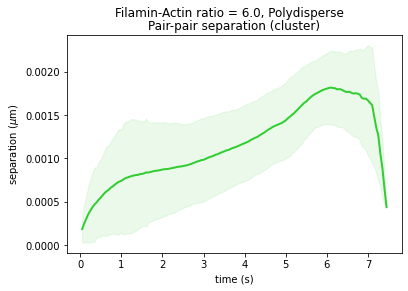

In [60]:
from numba import jit

@jit( nopython=True)
def dist2all(c,nT,nF,boxsize,boolRodsInside):
    # Calculate mean pair-pair filament distances for all filaments
    ppt=np.zeros(nF)
    p2p = np.zeros((nF,nF))
    
    for jf in range(nF):
        if not boolRodsInside[jf]:
            continue
        res = 0
        dist = np.absolute( c[jf,:]-c)
        # get distance to all other filaments
        for jf2 in range(nF):
            if not boolRodsInside[jf2] or jf==jf2:
                continue
            elif p2p[jf2,jf] == 0:
                res2=0
                # get distance
                #dist = np.absolute( c[jf,:]-c[jf2,:])
                for idx in range(3):
                    k = np.floor( dist[jf2,idx]/(0.5*boxsize[idx]))
                    dist[jf2,idx] -= k*boxsize[idx]
                    res2 += dist[jf2,idx]**2
                p2p[jf,jf2] = np.sqrt(res2)
                res += p2p[jf,jf2]
            else:
                res += p2p[jf2,jf]
        ppt[jf] = res/(np.sum(boolRodsInside)-1)
    return ppt

@jit( nopython=True)
def meanPairSep(c,nT,nF,boxsize,boolRodsInside):
    # Calculate and store mean pair-pair filament distances for all filaments for all time
    mu = np.zeros(nT)
    sig = np.zeros(nT)
    for it in range(nT):
        ppt=dist2all(c[it,:,:],nT,nF,boxsize,boolRodsInside[it])
        mu[it] = np.mean(ppt[ boolRodsInside[it] ])
        sig[it] = np.std(ppt[ boolRodsInside[it] ])
    return mu,sig

@jit( nopython=True)
def msd(lags,c,nT,nF,boxsize,boolRodsInside):
    mu = np.zeros(lags.shape)
    sig = np.zeros(lags.shape)
    for idx in range(lags.size):
        pptdiff = np.zeros(nT-lags[idx])
        for it in range(pptdiff.size):
            
            #find rods inside at both times
            rods_in = np.logical_and( boolRodsInside[it],boolRodsInside[it+lags[idx]])
            
            ppt1=dist2all(c[it,:,:],nT,nF,boxsize,rods_in)
            ppt2=dist2all(c[it+lags[idx],:,:],nT,nF,boxsize,rods_in)
            
            res = 0
            for idx2 in range(ppt1.size):
                res+=(ppt2[idx2]-ppt1[idx2])**2
            pptdiff[it] = res/ppt1.size
        mu[idx] = np.mean(pptdiff)
        sig[idx] = np.std(pptdiff)
    return mu,sig
t0 = time.time()
#rho_mu, rho_sig = meanPairSep(c,20,nF,boxsize, cct2)
lags = np.arange(1,nT)
rho_mu, rho_sig = msd(lags,c,nT,nF,boxsize, cct2)
fig,ax = plt.subplots()
ax.plot( dt*lags, rho_mu, color=cols['cluster'], label='cluster', linewidth=lw)
ax.fill_between( dt*lags, rho_mu-rho_sig, rho_mu+rho_sig, color=cols['cluster'], alpha=0.1)
ax.set(xlabel='time (s)', ylabel='separation ($\mu$m)', title='Pair-pair separation (cluster)')
fig.suptitle(ftitle)

print('time elapsed = {}'.format(time.time()-t0))

In [49]:
lags = np.arange(1,nT)
boolRodsInside = cct2
idx = 20
pptdiff = np.zeros(nT-lags[idx])
for it in range(pptdiff.size):
    rods_in = np.logical_and( boolRodsInside[it],boolRodsInside[it+lags[idx]])
            
    ppt1=dist2all(c[it,:,:],nT,nF,boxsize,rods_in)
    ppt2=dist2all(c[it+lags[idx],:,:],nT,nF,boxsize,rods_in)

    res = 0
    for idx2 in range(ppt1.size):
        res+=(ppt2[idx2]-ppt1[idx2])**2
    pptdiff[it] = res/ppt1.size
np.mean(pptdiff)

0.0007561921647473906

In [59]:
mu = np.zeros(lags.shape)
mu[0] = 0.04
mu

array([0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [44]:
res

1.1553198051361768

In [39]:
nn=1000

t0 = time.time()
for i in range(nn):
    ppt = dist2all(c[it,:,:],nT,nF,boxsize,cct2[it])
print('time elapsed = {}'.format(time.time()-t0))

t0 = time.time()
for i in range(nn):
    np.mean(ppt[ cct2[it] ])
print('time elapsed = {}'.format(time.time()-t0))

t0 = time.time()
for i in range(nn):
    np.std(ppt[ cct2[it] ])
print('time elapsed = {}'.format(time.time()-t0))

time elapsed = 4.214365243911743
time elapsed = 0.008659839630126953
time elapsed = 0.024543046951293945


In [55]:
t0 = time.time()
for i in range(nn):
    ppt = dist2all(c[it,:,:],nT,nF,boxsize,cct2[it])
print('time elapsed = {}'.format(time.time()-t0))

time elapsed = 1.4800388813018799


In [16]:
ppt2

NameError: name 'ppt2' is not defined

In [51]:
rho_mu

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Text(0.5, 0.98, 'Filamin-Actin ratio = 6.0, Polydisperse')

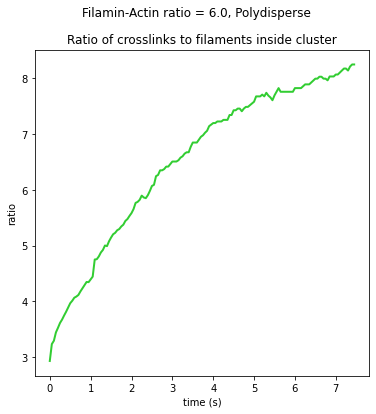

In [74]:
# num xlinks in biggest cluster
nprot = np.zeros(nT)
for it in range(nT):
    idxRods = np.where(cct2[it]==True)[0]
    tot=0
    for prot in ptlist[it]:
        if prot.link0 in idxRods or prot.link1 in idxRods:
            tot+=1
    nprot[it] = tot/np.sum(cct2[it])

fig,ax = plt.subplots(figsize=(6,6))
ax.plot(dt*np.arange(nT), nprot, color=cols['cluster'], linewidth=lw)
ax.set(xlabel='time (s)', ylabel='ratio', title='Ratio of crosslinks to filaments inside cluster')
fig.suptitle(ftitle)
#fig.savefig( os.path.join(rpath,'xlinkFractionInCluster.pdf') , bbox_inches='tight', dpi=600)

In [23]:
tot=0
idxRods = np.where(cct2[it]==True)[0]
for prot in ptlist[it]:
    if prot.link0 in idxRods or prot.link1 in idxRods:
        tot+=1
tot = tot/np.sum( cct2[it] )

In [60]:
it=10
idxRods = np.where(cct2[it]==True)[0]
tot=0
for prot in ptlist[it]:
    if (prot.link0 in idxRods) and (prot.link1 in idxRods):
        tot+=1
print( tot )

1976


In [65]:
prot.link1

247

In [63]:
idxRods

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18